# Batch Effect detection class

In [1]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


def pca_emb(features,n_components=2):
    X_emb = StandardScaler().fit_transform(features)
    X_emb = PCA(n_components=n_components).fit_transform(X_emb)
    return X_emb

def tsne_emb(features,n_components=2):
    X_emb = StandardScaler().fit_transform(features)
    X_emb = TSNE(n_components).fit_transform(X_emb)
    return X_emb

def umap_emb(features,n_components=2):
    X_emb = StandardScaler().fit_transform(features)
    X_emb = UMAP(n_components=n_components).fit_transform(X_emb)
    return X_emb

class BatchDetect():
    def __init__(self, metadata, features):
        self.metadata = metadata
        self.features = features
    
    def low_dim_visualization(self, method = "pca"):
        assert method.lower() in ["pca", "tsne", "umap"]

        if method == "pca":
            X_emb = pca_emb(self.features)
        elif method == "tsne":
            X_emb = tsne_emb(self.features)
        elif method == "umap":
            X_emb = umap_emb(self.features)
        
        ncols = metadata.shape[1]
        nrows = 1
        
        fig, ax = plt.subplots(nrows = nrows , 
                               ncols = ncols, 
                               figsize = (5*ncols, 5*nrows))
        for j in range(ncols):
            ax[j] = sns.scatterplot(x = X_emb[:,0],
                                    y = X_emb[:,1], 
                                    hue = metadata.iloc[:,j],
                                   ax = ax[j])
            
    def prince_plot(self,n_components=5):
        
        X_emb = pca_emb(self.features, 
                        n_components=n_components)
        
        ncols = metadata.shape[1]
        nrows = n_components
        
        heatmap_mat = pd.DataFrame(0., 
                                   columns=metadata.columns, 
                                   index = ["PC" + str(i) for i in range(n_components)])
        
        for i in range(nrows):
            for j in range(ncols):
                heatmap_mat.iloc[i,j] = f_classif(features[:,i:i+1],  
                                             metadata.iloc[:,j])[1][0]
        
        fig, ax = plt.subplots(figsize = (1*ncols, 1*nrows))
        
        ax = sns.heatmap(heatmap_mat, 
                         cmap = "Greys_r", 
                         annot=True, 
                         fmt=".3f",
                         ax = ax, 
                         vmin = 0, 
                         vmax = 0.05)
                
    def classification_test(self, scorer="accuracy", k_folds = 10):
        
        results = dict()
        
        results["feature"] = []
        results[scorer] = []
        results["method"] = []
        
        for col in metadata.columns:
        
            random_results = cross_val_score(
                estimator = DummyClassifier(strategy = "uniform"),
                    X = self.features,
                    y = self.metadata.loc[:,col],
                    cv = k_folds, 
                    scoring=scorer
            )
        
            results["feature"] +=[col]*k_folds
            results["method"] +=["random"]*k_folds
            results[scorer] +=random_results.tolist()
        
            rf_results = cross_val_score(
                estimator = RandomForestClassifier(),
                    X = self.features,
                    y = self.metadata.loc[:,col],
                    cv = k_folds, 
                    scoring=scorer
            )
        
            results["feature"] +=[col]*k_folds
            results["method"] +=["random forest"]*k_folds
            results[scorer] +=rf_results.tolist()
            
        results = pd.DataFrame(results)
        
        
        fig, ax = plt.subplots(figsize = (len(metadata.columns), 2))
        
        ax = sns.boxplot(data = results, 
                         x = "feature",
                        y = scorer,
                        hue = "method",
                        ax = ax)
        ax.legend(loc=(1.04, 0))

## creating a multi feature multi label dataset

In [2]:
from sklearn.datasets import make_multilabel_classification as make_ml_clf

X, Y = make_ml_clf(
        n_samples=200,
        n_features=20,
        n_classes=5,
        n_labels=4,
        allow_unlabeled=False,
    )

metadata = pd.DataFrame(Y, columns=["y1","y2","y3","y4","y5"])
features = X

X = Y = None

### lets assume each label is a source of batch effect

In [3]:
bd = BatchDetect(metadata, features)

# visualization with multiple labels

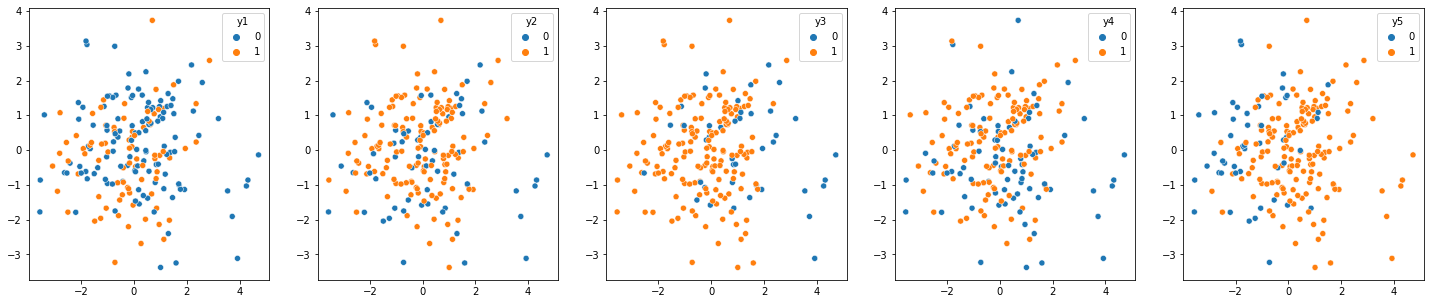

In [4]:
bd.low_dim_visualization("pca")

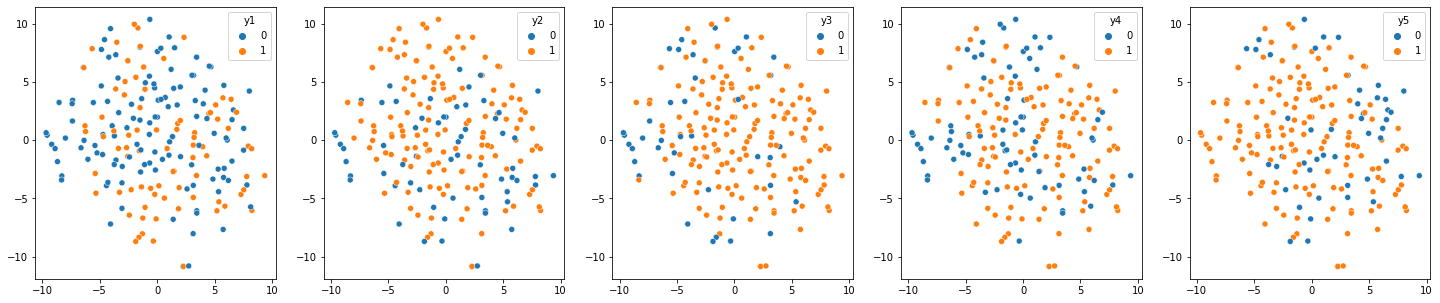

In [5]:
bd.low_dim_visualization("tsne")

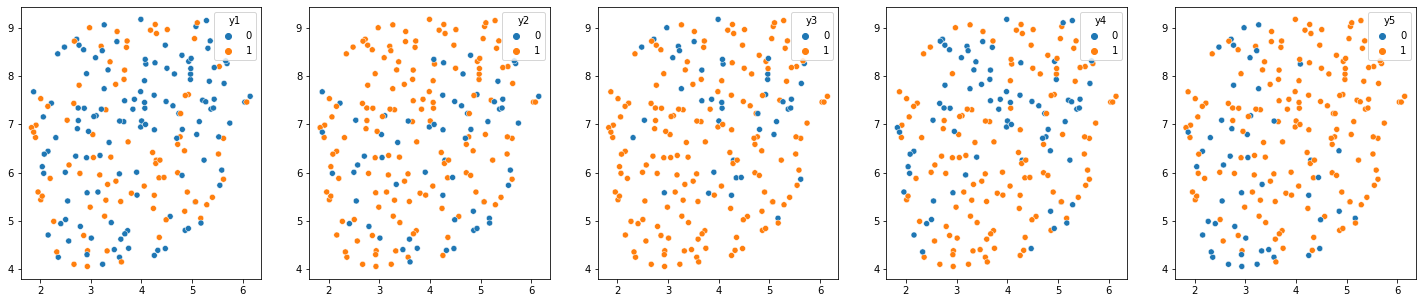

In [6]:
bd.low_dim_visualization("umap")

# Anova test of principal components vs. labels

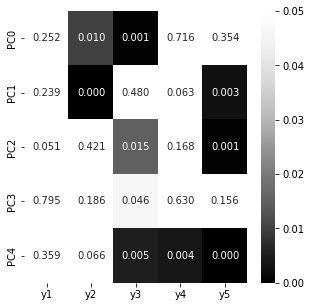

In [7]:
bd.prince_plot()

## classification test of  RF vs a random classifier

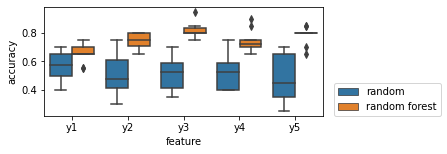

In [8]:
bd.classification_test()